In [1]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Code/'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from Dataset2 import ProcessingDatasetContainer



In [2]:
# Import Dataset Here

# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load('/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/Axis_Conv3d_Dataset.pt')
print(Dataset.Name)
print(Dataset.Truth_Keys)
Dataset.AssignIndices()
Dataset.State = 'Test'

Unassigned_Run010_Run030_Run080_Run090
('x', 'y', 'z', 'SDPPhi', 'CEDist', 'Xmax', 'LogE')


In [6]:
Variables = {'Axis':[0,1,2],'SDPPhi':3,'CEDist':4,'Xmax':5,'LogE':6}
FullTruth = []
FullPred  = []
FullRec   = []


for var, idx in Variables.items():
    print(f'Processing {var}')
    # Load Model
    Model = torch.load(f'Model_Axis_Conv_3d_Just{var}.pt')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    Model.to(device)
    torch.cuda.empty_cache()

    Dataset.State = 'Test'
    Dataset.BatchSize = 256
    Dataset.RandomIter = False

    Truth = []
    Pred  = []
    Rec   = []
    Model.eval()
    with torch.no_grad():
        for EventIdx,BatchMains,BatchAux,BatchTruth,BatchRec in Dataset:
            
            Truth.append(BatchTruth)
            Pred .append(Model(BatchMains,BatchAux).cpu())
            Rec  .append(BatchRec)

    Truth = torch.cat(Truth,dim=0)
    Pred  = torch.cat(Pred ,dim=0)
    Rec   = torch.cat(Rec  ,dim=0)

    # Extract the variable values
    FullTruth.append(Truth[:,idx])
    FullPred .append(Pred [:,idx])
    FullRec  .append(Rec  [:,idx])

for i in range(len(FullTruth)):
    if len(FullTruth[i].shape) == 1:
        FullTruth[i] = FullTruth[i].unsqueeze(1)
        FullPred[i]  = FullPred [i].unsqueeze(1)
        FullRec[i]   = FullRec  [i].unsqueeze(1)

FullTruth = torch.cat(FullTruth,dim=1)
FullPred  = torch.cat(FullPred,dim=1)
FullRec   = torch.cat(FullRec,dim=1)

FullTruth = Dataset.Unnormalise_Truth(FullTruth)
FullPred  = Dataset.Unnormalise_Truth(FullPred)
FullRec   = Dataset.Unnormalise_Truth(FullRec)

# Dropping NaNs
if True:
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~ torch.isnan(WeirdSum)
    FullTruth = FullTruth[Mask]
    FullPred  = FullPred[Mask]
    FullRec   = FullRec[Mask]

# To numpy
Truth = FullTruth.numpy()
Pred  = FullPred.numpy()
Rec   = FullRec.numpy()

Processing Axis
Processing SDPPhi
Processing CEDist
Processing Xmax
Processing LogE


In [9]:
# Remake geometry variables

# Chi0
# Chi0 = arccos(sqrt(x**2+z**2)) which are idx 0 and 2 and -90 deg
Chi0_Truth = np.arccos(np.sqrt(Truth[:,0]**2 + Truth[:,2]**2)) - np.pi/2
Chi0_Pred  = np.arccos(np.sqrt(Pred [:,0]**2 + Pred [:,2]**2)) - np.pi/2
Chi0_Rec   = np.arccos(np.sqrt(Rec  [:,0]**2 + Rec  [:,2]**2)) - np.pi/2

# Remake Rp
# Rp = CEDist * sin(180-Chi0)
Rp_Truth = Truth[:,4] * np.sin(np.pi - Chi0_Truth)
Rp_Pred  = Pred [:,4] * np.sin(np.pi - Chi0_Pred)
Rp_Rec   = Rec  [:,4] * np.sin(np.pi - Chi0_Rec)

# Combine them
Comb_Truth = np.stack([Chi0_Truth,Rp_Truth],axis=1)
Comb_Pred  = np.stack([Chi0_Pred ,Rp_Pred ],axis=1)
Comb_Rec   = np.stack([Chi0_Rec  ,Rp_Rec  ],axis=1)

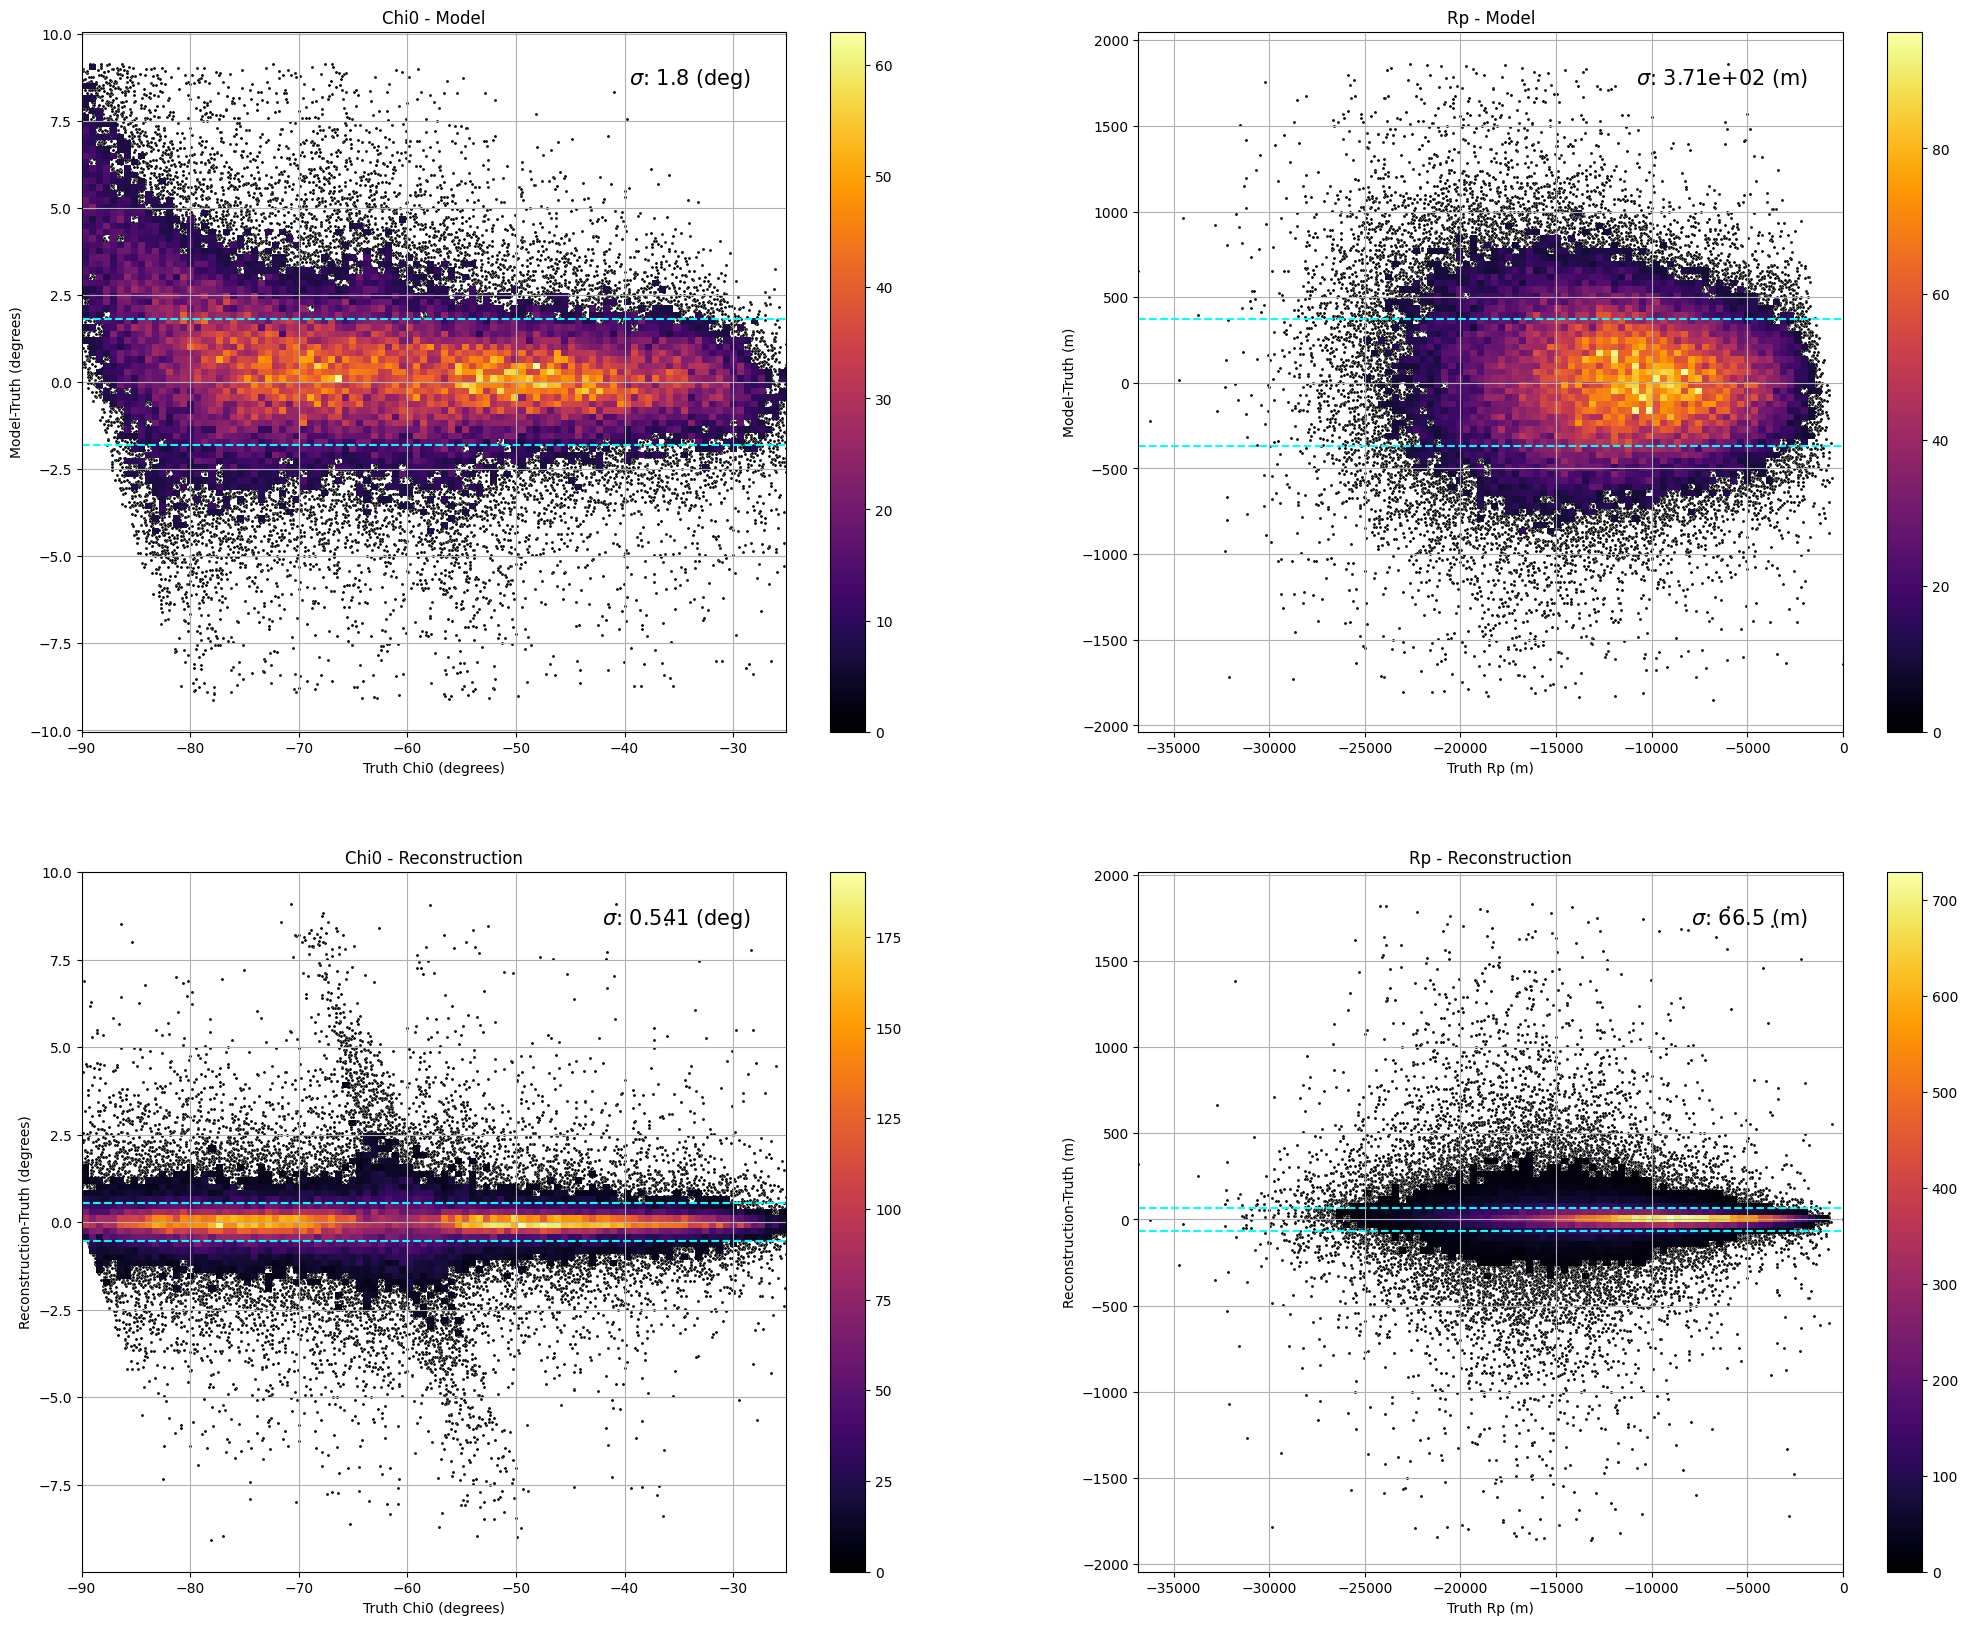

In [10]:
def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    fig, ax = plt.subplots(2, len(TruthKeys), figsize=(12.5*len(TruthKeys), 20))
    
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        elif TruthKeys[i] == 'SDPPhi': cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3)    & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'  : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'    : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist': cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'    : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'  : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'  : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'     : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        sns.scatterplot(x=X, y=Yp, ax=ax[0,i], s=5,color='black')
        sns.scatterplot(x=X, y=Yr, ax=ax[1,i], s=5,color='black')

        sns.histplot(x=X, y=Yp, ax=ax[0,i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[1,i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[0,i].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[1,i].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[0,i].set_ylabel(f'Model-Truth (degrees)')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[1,i].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[0,i].set_title(f'{TruthKeys[i]} - Model')
        ax[1,i].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[0,i].set_xlim(min(X),max(X))
        ax[1,i].set_xlim(min(X),max(X))

        ax[0,i].grid()
        ax[1,i].grid()

        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[0,i].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[1,i].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[0,i].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[0,i].transAxes, fontsize=15)
            ax[1,i].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[1,i].transAxes, fontsize=15)

        else:
            ax[0,i].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[0,i].transAxes, fontsize=15)
            ax[1,i].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[1,i].transAxes, fontsize=15)



        ax[0,i].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[0,i].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[1,i].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[1,i].axhline(-Percentile68_r, color='cyan', linestyle='--')

    return fig
    
TruthKeys  = ['Chi0','Rp']
TruthUnits = ['rad','m']
figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Comb_Truth,Comb_Pred,Comb_Rec)
# figure.savefig(f'../Results/{Name}_Combined_Deviation.png')

In [15]:
# Rp_Truth = Rp_Truth
# Rp_Pred  = Rp_Pred
# Rp_Rec   = Rp_Rec

LogE_Truth = Truth[:,6]
LogE_Pred  = Pred [:,6]
LogE_Rec   = Rec  [:,6]

# Deviations
Rp_Pred_Diff = Rp_Pred - Rp_Truth
Rp_Rec_Diff  = Rp_Rec  - Rp_Truth

X = LogE_Truth
Y_p = Rp_Pred_Diff
Y_r = Rp_Rec_Diff

cut = X>18
X = X[cut]
Y_p = Y_p[cut]
Y_r = Y_r[cut]





